# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [17]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [18]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [19]:
build_new_dataset = {'True': True, 'False': False}.get(input('Build New Dataset? (Bool)'))
if build_new_dataset:
    symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
else:
    symbol_list = 'filtered'

train_new_model = {'True': True, 'False': False}.get(input('Train New Model? (Bool)'))
if train_new_model:
    minimum_feature_threshold = 0.9
    param_grid = {
            'shuffle': [True], 
            'solver': ['adam'], 
            'learning_rate': ['adaptive'],
            'tol': [0.0001],
            'max_iter': [200],
            'alpha': [0.0001],
            'hidden_layer_sizes': [ast.literal_eval(input('Hidden Layers: eg. "(100, 100), (500, 500)"'))],
            'learning_rate_init': [0.001],
            'n_iter_no_change': [9]
        }
    verticle_jobs = 1 #'-1' for max

if build_new_dataset or train_new_model:
    debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))
else:
    debugging = False

## Data Preparation

In [20]:
symbols = []
if symbol_list == 'filtered':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = np.random.choice(all_symbols, num_symbols, replace=False).tolist()
    symbols = symbols + pd.read_csv("../data/filtered_tickers.csv")["Ticker"].tolist()

symbols = symbols + pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['PHD', 'GFA', 'CSUN', ..., 'NTES', 'WB', 'SYDB.CO'], dtype=object)

#### Download annual financial data

In [21]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv('../data/filtered_tickers.csv')
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan
            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'
            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]
            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]
            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]
            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1
                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'
                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]
                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]
                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) == 5 and ticker_df.isna().sum().sum() < round(352 * minimum_feature_threshold):
                if symbol not in filtered_pd['Ticker'].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{'Ticker': symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd['Ticker'].tolist():
                    filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                    if debugging:
                        print(f'Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(352 * minimum_feature_threshold)}')
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd['Ticker'].tolist():
                filtered_pd = filtered_pd[filtered_pd['Ticker'] != symbol]
                if debugging:
                    print(f'Removed {symbol} from filtered tickers because an exception was raised')
            continue
    filtered_pd.to_csv('../data/filtered_tickers.csv', index=False)
    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

  0%|          | 0/1487 [00:00<?, ?it/s]

100%|██████████| 1487/1487 [31:11<00:00,  1.26s/it]


### Short visualisation

In [22]:
df

,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Net Income From Tax Loss Carryforward,Depletion,Current Deferred Taxes Liabilities,Other Cash Adjustment Inside Changein Cash,Dividend Paid Cfo,Current Deferred Taxes Assets,Duefrom Related Parties Non Current,Investmentsin Subsidiariesat Cost,Dueto Related Parties Non Current,Fixed Assets Revaluation Reserve
0,WRLD,2025-03-31,NaN,NaN,NaN,Financial Services,Credit Services,2.568057e+08,-6.602755e+07,-4.239846e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WRLD,2024-03-31,-0.165471,-0.217616,-0.089530,Financial Services,Credit Services,2.598506e+08,-3.620453e+07,-4.042358e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WRLD,2023-03-31,0.692175,0.591050,0.792311,Financial Services,Credit Services,2.857260e+08,-1.431409e+07,-4.101766e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WRLD,2022-03-31,-0.414929,-0.500156,-0.578347,Financial Services,Credit Services,2.663761e+08,-1.111393e+08,-5.238553e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WRLD,2021-03-31,0.234895,0.488671,0.463163,Financial Services,Credit Services,2.152699e+08,-1.024523e+08,-3.576708e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,UBER,2025-03-31,NaN,NaN,NaN,Technology,Software - Application,2.250000e+09,-1.785000e+09,-4.700000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961,UBER,2023-12-31,0.219354,0.114032,-0.025024,Technology,Software - Application,3.362000e+09,0.000000e+00,-2.871000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962,UBER,2022-12-31,0.281844,0.745653,1.489689,Technology,Software - Application,3.900000e+08,0.000000e+00,-2.640000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963,UBER,2021-12-31,-0.141903,-0.491057,-0.410208,Technology,Software - Application,-7.430000e+08,-4.462500e+08,-8.420000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [24]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Ticker', 'Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [25]:
pred_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    pred_data = pd.concat([pred_data, df.iloc[[i*5]]]) 
print('Prediction Data:')
display(pred_data)

train_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    train_data = pd.concat([train_data, df.iloc[[1+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[4+i*5]]])
print('Train and Test Data:')
display(train_data)

Prediction Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Net Income From Tax Loss Carryforward,Depletion,Current Deferred Taxes Liabilities,Other Cash Adjustment Inside Changein Cash,Dividend Paid Cfo,Current Deferred Taxes Assets,Duefrom Related Parties Non Current,Investmentsin Subsidiariesat Cost,Dueto Related Parties Non Current,Fixed Assets Revaluation Reserve
0,386,2025-03-31,NaN,NaN,NaN,5,27,-0.048582,0.129555,5.072739e-02,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
5,149,2025-03-31,NaN,NaN,NaN,0,99,-0.048771,0.000000,5.092843e-02,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
10,115,2025-03-31,NaN,NaN,NaN,8,84,-0.048481,0.096858,5.021223e-02,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
15,90,2025-03-31,NaN,NaN,NaN,6,62,-0.048738,0.000000,5.084355e-02,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
20,280,2025-02-28,NaN,NaN,NaN,9,96,-0.048290,0.149310,7.282004e-18,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,134,2025-03-31,NaN,NaN,NaN,4,68,-0.044491,-0.014945,5.075602e-02,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
1945,364,2025-03-31,NaN,NaN,NaN,2,8,-0.048293,0.000000,5.028594e-02,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
1950,43,2024-12-31,NaN,NaN,NaN,2,58,0.001632,-16.716697,4.456738e-02,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
1955,203,2024-12-31,NaN,NaN,NaN,1,38,-0.048428,0.000000,5.021588e-02,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,4.205483e+01,0.0,-2.613903e+00,0.0


Train and Test Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Net Income From Tax Loss Carryforward,Depletion,Current Deferred Taxes Liabilities,Other Cash Adjustment Inside Changein Cash,Dividend Paid Cfo,Current Deferred Taxes Assets,Duefrom Related Parties Non Current,Investmentsin Subsidiariesat Cost,Dueto Related Parties Non Current,Fixed Assets Revaluation Reserve
1,386,2024-03-31,-0.165471,-0.217616,-0.089530,5,27,-0.048580,0.138478,0.050737,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
2,386,2023-03-31,0.692175,0.591050,0.792311,5,27,-0.048562,0.145027,0.050734,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
3,386,2022-03-31,-0.414929,-0.500156,-0.578347,5,27,-0.048575,0.116058,0.050680,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
4,386,2021-03-31,0.234895,0.488671,0.463163,5,27,-0.048612,0.118657,0.050759,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
6,149,2023-12-31,0.324476,0.233752,0.272999,0,99,-0.048754,0.000000,0.050928,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,203,2020-12-31,-0.048055,-0.134439,-0.731121,1,38,-0.049293,0.000000,0.047072,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,9.818913e+00,0.0,8.370926e+00,0.0
1961,370,2023-12-31,0.219354,0.114032,-0.025024,9,96,-0.046375,0.149310,0.049560,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
1962,370,2022-12-31,0.281844,0.745653,1.489689,9,96,-0.048487,0.149310,0.050804,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
1963,370,2021-12-31,-0.141903,-0.491057,-0.410208,9,96,-0.049293,0.015796,0.050528,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0


### Labeling

In [27]:
X_pred = pred_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
X_train = train_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

display(X_train)
display(y_train)
display(X_test)
display(y_test)

,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,...,Net Income From Tax Loss Carryforward,Depletion,Current Deferred Taxes Liabilities,Other Cash Adjustment Inside Changein Cash,Dividend Paid Cfo,Current Deferred Taxes Assets,Duefrom Related Parties Non Current,Investmentsin Subsidiariesat Cost,Dueto Related Parties Non Current,Fixed Assets Revaluation Reserve
1469,119,4,67,-0.048769,0.000000,0.050929,-0.050728,0.049836,-0.110285,-0.185619,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
1362,372,9,26,-0.048771,0.145410,0.050882,-0.050657,0.049824,-0.109878,-0.177004,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
948,13,5,54,-0.050141,0.000912,0.049507,-0.047609,0.000000,-0.095242,-0.166662,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
1011,289,5,11,-0.048760,0.149248,0.050571,-0.050295,0.049836,0.000000,0.000000,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
1683,286,2,89,-0.048318,0.149310,0.050870,-0.050464,0.049664,-0.013468,-0.099999,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,301,2,43,-0.048763,0.148431,0.050901,-0.050674,0.049832,-0.108366,-0.181948,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
128,197,9,94,-0.042278,-0.573234,0.049737,-0.047909,0.036679,-0.007748,1.603900,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
1814,357,7,98,-0.048798,0.000000,0.050840,-0.050633,0.049829,-0.105474,-0.177736,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0
1676,279,4,69,-0.047224,0.149310,0.050405,-0.050732,0.049475,-0.039359,-0.131076,...,0.0,0.0,2.697546e-15,0.0,0.0,0.0,-3.326156e-16,0.0,-8.346636e-16,0.0


,3M Future Change,6M Future Change,1Y Future Change
1469,0.179245,0.240566,0.084906
1362,-0.512734,-0.537722,-0.548775
948,0.302051,0.128707,0.262020
1011,-0.074074,-0.029422,0.195225
1683,-0.189778,-0.393250,-0.427194
...,...,...,...
704,1.036108,1.003391,0.466925
128,-0.058709,-0.283373,-0.466427
1814,0.101835,-0.353211,-0.899083
1676,0.185413,0.222502,0.200094


,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,...,Net Income From Tax Loss Carryforward,Depletion,Current Deferred Taxes Liabilities,Other Cash Adjustment Inside Changein Cash,Dividend Paid Cfo,Current Deferred Taxes Assets,Duefrom Related Parties Non Current,Investmentsin Subsidiariesat Cost,Dueto Related Parties Non Current,Fixed Assets Revaluation Reserve
351,88,1,15,-0.048760,0.146553,5.091322e-02,-5.071686e-02,0.049821,-0.098372,-0.185258,...,0.0,0.0,2.697546e-15,0.0,0.0,0.000000,-3.326156e-16,0.0,-8.346636e-16,0.0
912,315,8,80,-0.048864,0.132407,4.684211e-02,-4.595498e-02,0.000000,-0.012716,-0.181737,...,0.0,0.0,2.697546e-15,0.0,0.0,0.000000,-3.326156e-16,0.0,-8.346636e-16,0.0
514,365,9,34,-0.048726,0.138654,5.083806e-02,-5.057406e-02,0.049771,-0.103234,-0.171022,...,0.0,0.0,2.697546e-15,0.0,0.0,0.000000,-3.326156e-16,0.0,-8.346636e-16,0.0
1076,359,7,100,-0.048648,0.142817,5.087246e-02,-5.072064e-02,0.049822,-0.107077,-0.154405,...,0.0,0.0,2.697546e-15,0.0,0.0,0.000000,-3.326156e-16,0.0,-8.346636e-16,0.0
1654,163,5,53,-0.048733,0.145769,5.090905e-02,-5.073199e-02,0.000000,-0.109325,-0.185352,...,0.0,0.0,2.697546e-15,0.0,0.0,0.000000,-3.326156e-16,0.0,-8.346636e-16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,194,2,45,-0.048130,0.149310,5.054747e-02,-5.038636e-02,0.049742,-0.071158,-0.067814,...,0.0,0.0,2.697546e-15,0.0,0.0,-2.406583,-3.326156e-16,0.0,-8.346636e-16,0.0
1193,346,9,22,-0.048767,0.000000,5.092973e-02,-5.073199e-02,0.049836,-0.110280,-0.185595,...,0.0,0.0,2.697546e-15,0.0,0.0,0.000000,-3.326156e-16,0.0,-8.346636e-16,0.0
1463,209,7,17,-0.048726,0.148811,5.089685e-02,-5.064402e-02,0.049824,-0.104104,-0.183980,...,0.0,0.0,2.697546e-15,0.0,0.0,0.000000,-3.326156e-16,0.0,-8.346636e-16,0.0
1767,15,9,96,-0.048745,0.146541,7.282004e-18,3.464062e-17,0.049833,0.000000,0.000000,...,0.0,0.0,2.697546e-15,0.0,0.0,0.000000,-3.326156e-16,0.0,-8.346636e-16,0.0


,3M Future Change,6M Future Change,1Y Future Change
351,-0.335185,-0.629630,-0.869074
912,0.033557,0.001549,0.216132
514,0.082609,0.041304,0.073913
1076,0.313944,0.058297,-0.111266
1654,0.040740,-0.023100,-0.089865
...,...,...,...
1266,-0.173851,-0.257874,-0.348183
1193,-0.339450,-0.633028,-0.420183
1463,-0.298722,-0.267572,-0.239617
1767,-0.172466,-0.154880,0.058410


## Model Training

In [28]:
if train_new_model:
    base_model = MLPRegressor()

    grid_search = GridSearchCV(
        estimator=base_model, 
        param_grid=param_grid, 
        scoring='r2', 
        cv=3, 
        n_jobs=3,
        verbose=verticle_jobs,
    )
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    model = grid_search.best_estimator_
    print('Best Parameters:')
    print(best_params)

    model.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Parameters:
{'alpha': 0.0001, 'hidden_layer_sizes': (1000, 1000, 1000), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 9, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001}


## Testing and benchmarking

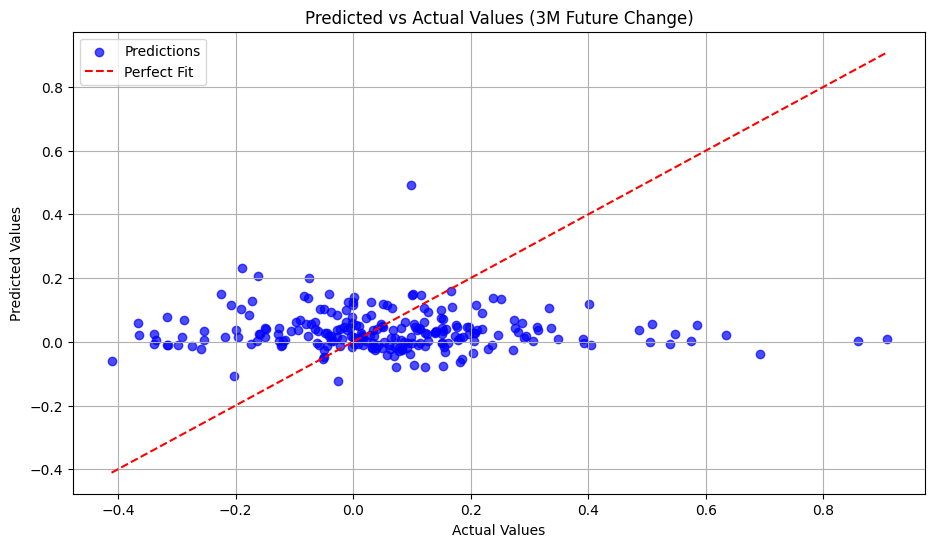

3M Future Change - R²: -0.1379
3M Future Change - MSE: 0.0471
3M Future Change - MAE: 0.1613


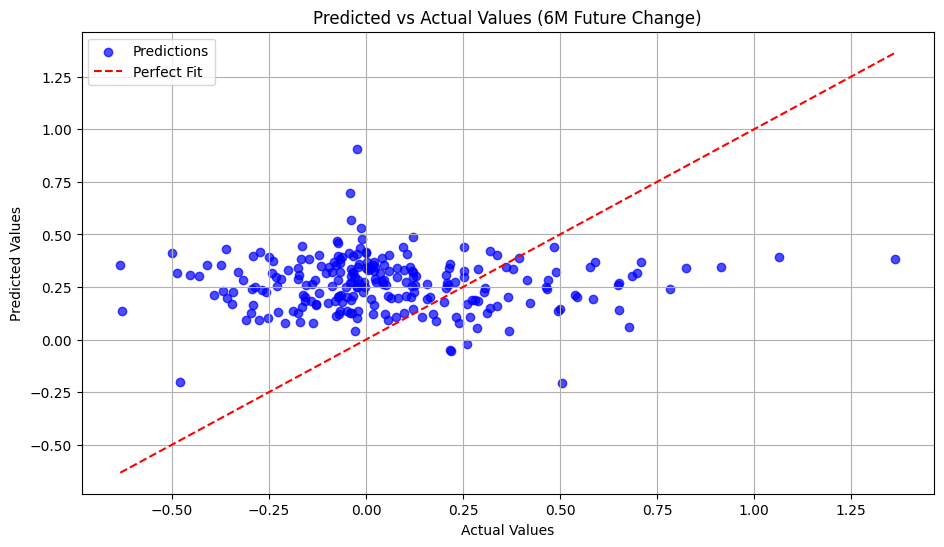

6M Future Change - R²: -0.7370
6M Future Change - MSE: 0.1471
6M Future Change - MAE: 0.3270


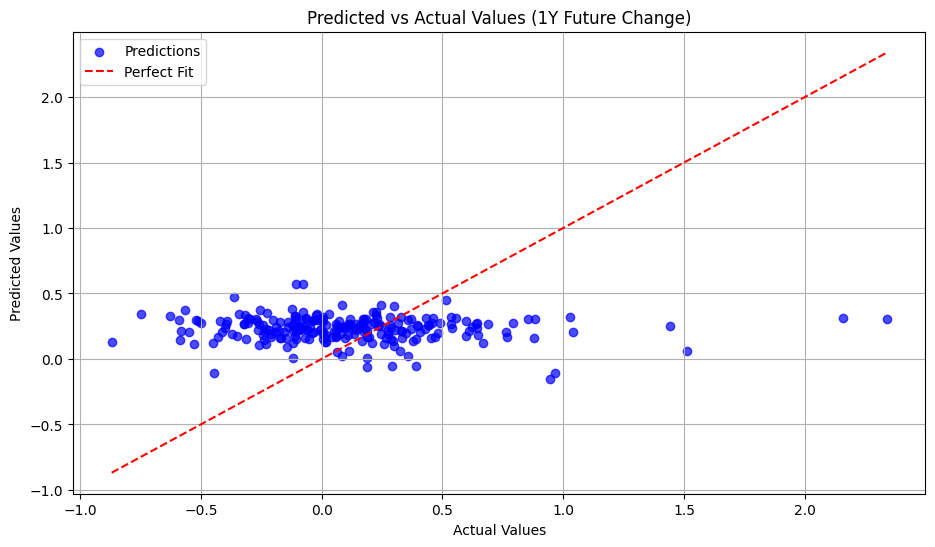

1Y Future Change - R²: -0.1833
1Y Future Change - MSE: 0.2039
1Y Future Change - MAE: 0.3458

Overall Scores:
Mean - R²: -0.3527
Mean - MSE: 0.1327
Mean - MAE: 0.2780


In [29]:
if train_new_model:
    y_test_pred = model.predict(X_test)

    for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
        y_test_actual = y_test[target]
        y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [30]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        'hidden_layer_sizes': [model.hidden_layer_sizes],
        'max_iter': model.max_iter,
        'n_iter_no_change': model.n_iter_no_change,
        'learning_rate': model.learning_rate,
        'learning_rate_init': model.learning_rate_init,
        'batch_size': model.batch_size,
        'tol': model.tol,
        'alpha': model.alpha,
        'shuffle': model.shuffle,
    })
    test_results.to_csv('../data/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../models/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

## Predictions on latest data

In [31]:
best_r2 = pd.read_csv('../models/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


Best model R²: -0.0893079795170797


In [32]:
df_raw = pd.read_csv('../data/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_1y) / 3
    results.append({
        'Ticker': df_raw.loc[i*5, 'Ticker'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Dividends Received Direct


In [ ]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"The author was stupid and forgot to cover this obvious, famous stock. Try another.", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "")

In [ ]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker (e.g. 'TSLA' or 'MATAS.CO')"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a8c968acf9d317b028.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
